In [ ]:
# Run this if latest_forecast.csv is not yet downloaded locally
# !python get_538_forecast.py

In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz

/home/vivian/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
def seperate_parties():
    '''
    Seperates Ds and Rs from Each District
    returns dataframe with one row per candidate
    
    '''
    # Read in files 
    odds = pd.read_csv("latest_forecast.csv")
    # make two dataframes, it's the previous ones but we removed the opposite party
    dems = odds.drop(columns = ["name_R1", "winner_R1"])
    repubs = odds.drop(columns = ["name_D1", "winner_D1"])

    # Add Columns of party name
    dems["party"] = ["D"] * len(dems)
    repubs["party"] = ["R"] * len(repubs)

    # rename columns to be same-named in both dataframes
    dems = dems.rename(columns = {"name_D1": "name", "winner_D1": "win_pct"})
    repubs = repubs.rename(columns = {"name_R1": "name", "winner_R1": "win_pct"})

    # concatenate into end result dataframe
    total_odds = pd.concat((dems, repubs)).sort_values(by=["district"]).reset_index(drop=True)
    
    # Add STATE-DISTRICT-PARTY index to each candidate
    dist = total_odds["district"]
    party = total_odds["party"]
    idx = ["{}-{}".format(dist[i],party[i]) for i in range(len(total_odds))]
    
    total_odds.index = idx
    return total_odds
    

In [3]:
def get_finance_df():
    # Function to return Finance Dataframe from FEC
    # Download dataframe
    finance_df = pd.read_csv("https://www.fec.gov/files/bulk-downloads/2022/candidate_summary_2022.csv")
    
    # Drop un-needed columns
    finance_df = finance_df.drop(columns = ['Link_Image', 'Cand_Id', 'Debt_Owed_By_Committee',
       'Coverage_End_Date', 'Cand_Street_1', 'Cand_Street_2', 'Cand_City',
       'Cand_State', 'Cand_Zip', 'Individual_Itemized_Contribution',
       'Individual_Unitemized_Contribution', 'Individual_Contribution',
       'Other_Committee_Contribution', 'Party_Committee_Contribution',
       'Cand_Contribution', 'Total_Contribution',
       'Transfer_From_Other_Auth_Committee', 'Cand_Loan', 'Other_Loan',
       'Total_Loan', 'Offsets_To_Operating_Expenditure',
       'Offsets_To_Fundraising', 'Offsets_To_Leagal_Accounting',
       'Other_Receipts', 'Operating_Expenditure',
       'Exempt_Legal_Accounting_Disbursement', 'Fundraising_Disbursement',
       'Transfer_To_Other_Auth_Committee', 'Cand_Loan_Repayment',
       'Other_Loan_Repayment', 'Total_Loan_Repayment', 'Individual_Refund',
       'Party_Committee_Refund', 'Other_Committee_Refund',
       'Total_Contribution_Refund', 'Other_Disbursements', 'Net_Contribution',
       'Net_Operating_Expenditure', 'Cash_On_Hand_BOP',
       'Debt_Owe_To_Committee', 'Coverage_Start_Date'])

    # Select only House Races
    finance_df = finance_df.query('Cand_Office == "H"')
    finance_df = finance_df.drop(columns = ["Cand_Office"])
    
    # Combine Districts for finance dataframe
    fix = lambda a: 1 if a == 0 else int(a)
    districts =     ["{}-{}".format(finance_df.iloc[i]["Cand_Office_St"],
                                    fix(finance_df.iloc[i]["Cand_Office_Dist"])) 
                     for i in range(len(finance_df))]
    finance_df["district"] = districts
    finance_df = finance_df.drop(columns = ["Cand_Office_St", "Cand_Office_Dist"])
    
    return finance_df

In [4]:
def get_combined_df():
    # Function to get a 538 / FEC combined dataset
    
    # Get dataframes to combine
    fin_df = get_finance_df()
    df_538 = seperate_parties()
    
    # Sorting fin_df so best funded candidates are first - makes finding a candidate faster
    fin_df = fin_df.sort_values(by=["Total_Receipt"], ascending = False)
    
    # Find best match for each candidate
    # establish dictionary to store fin index : 538 index in finance DF
    reference_dict = {}
    
    for i in df_538.index:
        # Get info about our candidate
        row = df_538.loc[i]
        district = row["district"]
        party = "DEM" if row["party"] == "D" else "REP"
        name = row["name"]
        
        # Get everyone that's the same party in the same district
        dist_party_538 = fin_df.query('district == @district').query('Cand_Party_Affiliation == @party')
        
        # Find which person from same party and same district has closest name
        perfect = False
        close = False
        best = 0
        best_row = None
        for j in dist_party_538.index:
            fin_row = dist_party_538.loc[j]
            r = fuzz.token_set_ratio(name,fin_row["Cand_Name"])
            if r >= 99:
                reference_dict[j] = i
                perfect = True
                break
            if r >= 60:
                close = True
                if r > best:
                    best = r
                    best_row = j
                
        
        if close:
            # use the best match
            reference_dict[best_row] = i
    print("Successfully matched {:.1f}% of candidates".format(100*len(reference_dict)/len(df_538)))
    # Set finance dataframe index to match matched candidate from 
    # https://stackoverflow.com/questions/48798687/pandas-replace-indexes-of-rows-according-to-a-dictionary
    s = fin_df.index.to_series()
    fin_df.index = s.map(reference_dict).fillna(s)
    fin_df = fin_df.drop(columns=['Cand_Name', 'Cand_Party_Affiliation','district'])
    print("fin_df cols:", fin_df.columns)
    print("df_538 cols:", df_538.columns)
    
    return df_538.join(fin_df)
    
    
        

In [8]:
combined_df = get_combined_df()

Successfully matched 98.1% of candidates
fin_df cols: Index(['Cand_Incumbent_Challenger_Open_Seat', 'Total_Receipt',
       'Total_Disbursement', 'Cash_On_Hand_COP'],
      dtype='object')
df_538 cols: Index(['branch', 'district', 'forecastdate', 'name', 'win_pct', 'tipping',
       'timestamp', 'party'],
      dtype='object')


In [9]:
import plotly.express as px

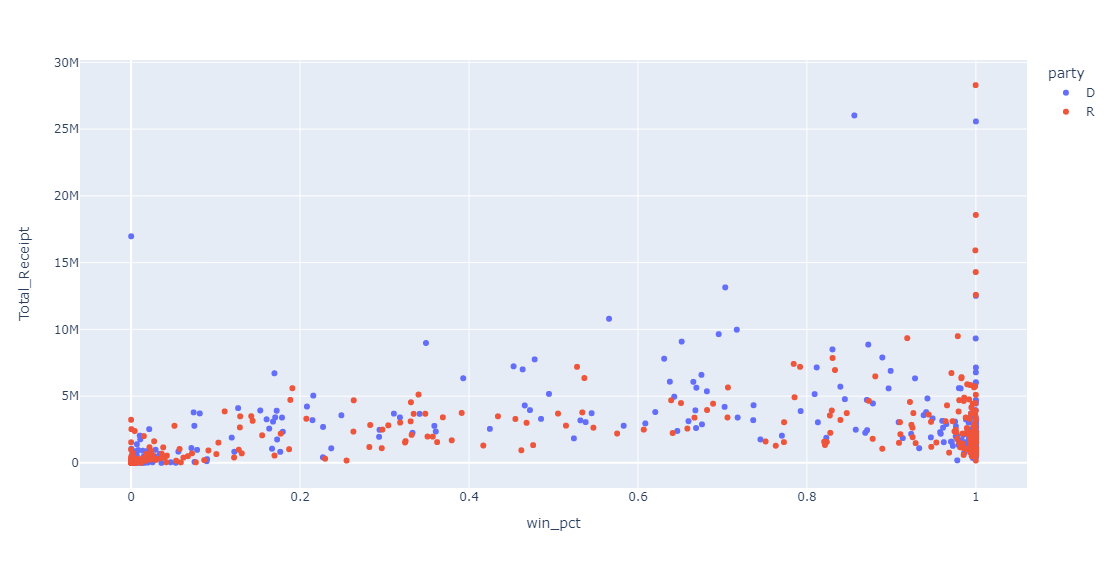

In [16]:
px.scatter(combined_df, x="win_pct", y="Total_Receipt", color= "party", hover_data = ["name", "district"])

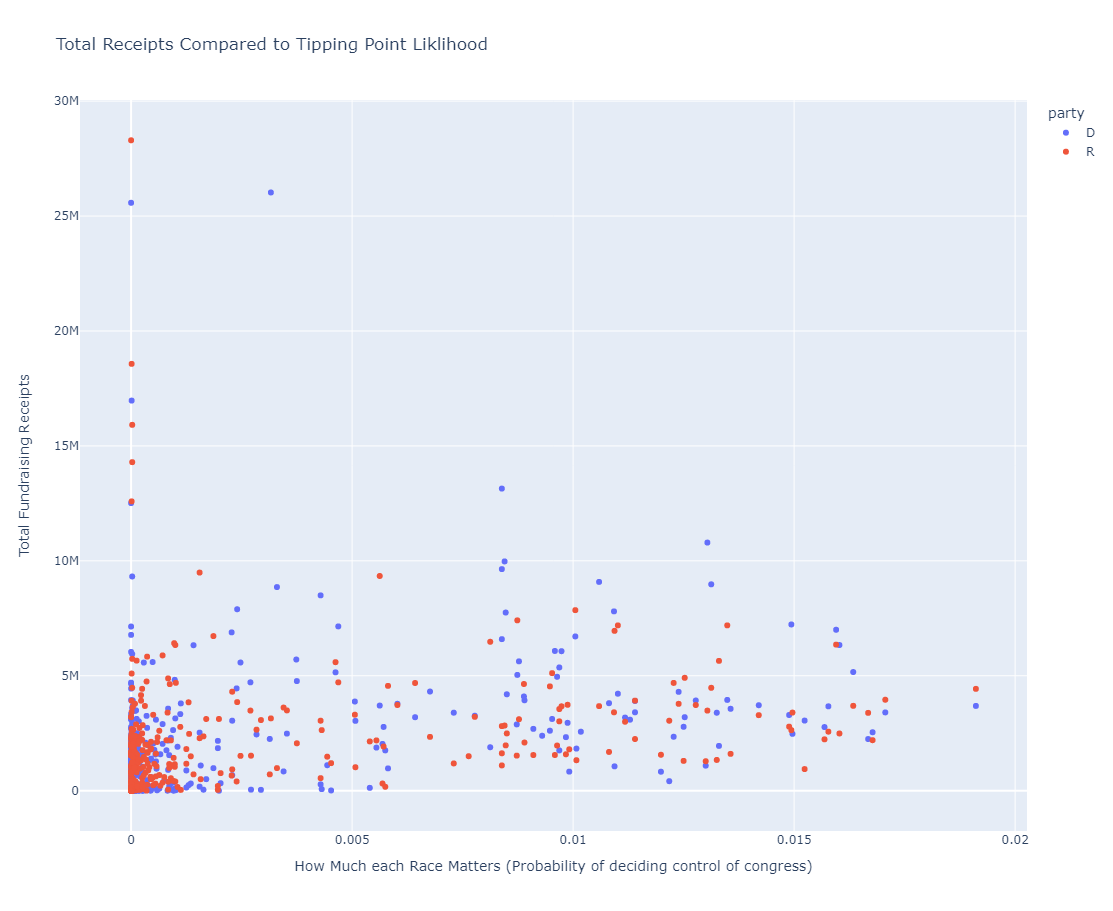

In [27]:
fig = px.scatter(combined_df, x="tipping", y="Total_Receipt", color= "party", hover_data = ["name", "district"],
                title = "Total Receipts Compared to Tipping Point Liklihood",
                labels = {"Total_Receipt": "Total Fundraising Receipts",
                          "tipping": "How Much each Race Matters (Probability of deciding control of congress)"}
                )
fig.show()
fig.write_html("receipts_vs_tipping.html")